Copyright (c) 2017, Hiori Kino

All rights reserved.

This software is released under the BSD License (3-clause BSD License). 

#### descriptorをつくるためのものその1。

# read xsf and generate descriptors for clustering 


use multiidnex dataframe to express
data(crystal id, atom id, descriptors)

# 1. data preparation

structure search of eight carbon atoms with periodic GRRM

Makito Takagi, Tetsuya Taketsugu, Hiori Kino, Yoshitaka Tateyama, Kiyoyuki Terakura, and Satoshi Maeda,
"Global search for low-lying crystal structures using the artificial force induced reaction method: A case study on carbon",
Phys. Rev. B 95, 184110, (2017)

There exist structure, total energy data in the supplement. 
I changed them to the xsf format and stored them in the Maeda_carbon8_xsf/ directory

## geometry
in the case of sieta PBE+D2, graphite structure is 

* the nearest neighbour distance is 1.4 Ang along the ab-plane.
* the interlayer distance along the c direction is 3.4Ang


I used the cutoff 3.0Ang. 


## Reference


### descriptor 
1. Jörg Behler and Michele Parrinello, "Generalized Neural-Network Representation of High-Dimensional Potential-Energy Surfaces", Phys. Rev. Lett. 98, 146401(2007) 


### pymatgen
1. Shyue Ping Ong, William Davidson Richards, Anubhav Jain, Geoffroy Hautier, Michael Kocher, Shreyas Cholia, Dan Gunter, Vincent Chevrier, Kristin A. Persson, Gerbrand Ceder. "Python Materials Genomics (pymatgen) : A Robust, Open-Source Python Library for Materials Analysis". Computational Materials Science, 2013, 68, 314–319. 


This script executes

1. read crystal structure in the xsf format.
1. change them to the descriptor with Behler's symmetry functions.
1. show pairplot and confirm that they are not linearly dependent. 


## 2. data preprocessing

In [1]:


from __future__ import print_function

import os
import numpy as np

have_pymatgen = True
try:
    import pymatgen.io.xcrysden
except:
    have_pymatgen = False
if have_pymatgen:
    import pymatgen.core.structure
print("have_pymatgen",have_pymatgen)

import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

import sklearn.preprocessing
import pickle

import glob

import copy

have_pymatgen True


# make descriptor


## Necessity of descriptors of  crystals

1. translational invariance
1. axis rotational invariance
1. atomic permutation invariance

## I adopt Behler's symmetry function here

The total energy of the crystal is the summation of the atomic energy, $i$. 
$$ E = \sum_i  E^{a}(i) $$
We assume that the atomic energy of $i$ is written as a function of neighbouring atoms. 

In the case of linear regression, it is expressed withe desriptors, $G$, 
$$ E^{a}(i) = \sum_{j}^{r_{ij} < r_c} \sum_{a,r_p} c_{a,r_p} G(r_{ij}, a, r_p) $$

The descriptor, $G$ is 
$$ G(r_{ij}, a, r_p, r_c) = \exp( -( r_{ij} - r_p )^2/a^2 ) f_c(r_{ij}, r_c) $$
where $f_c$ the cutoff function with fixed cutoff parameter, $r_{c}$,  
$$ f_c(r_{ij}, r_c) = (\cos( \pi r_{ij} / r_c ) + 1 )*0.5 $$



plot shape of symmetry functions


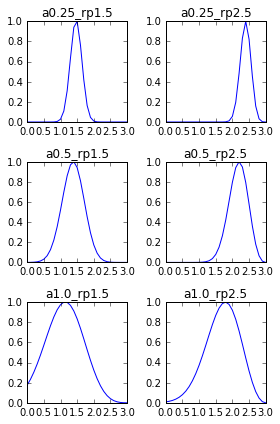

len= 6 , param= {'rc': 3, 'gauss2': {'a': array([ 0.25,  0.25,  0.5 ,  0.5 ,  1.  ,  1.  ]), 'list': {'a': [0.25, 0.5, 1.0], 'rp': array([ 1.5,  2.5])}, 'rp': array([ 1.5,  2.5,  1.5,  2.5,  1.5,  2.5]), 'labels': ['a0.25_rp1.5', 'a0.25_rp2.5', 'a0.5_rp1.5', 'a0.5_rp2.5', 'a1.0_rp1.5', 'a1.0_rp2.5']}}


In [2]:
"""
plot the form of $G(r)$
"""

def makesymfun1():
    """
    tyme 1 of the symmetry function parameter
    
    @return : dict 
    """
    
    """
    use dict of python
    """
    eps = 1e-5
    xmax = 3 # = rc in Ang. 
    alist = [ 0.25, 0.5, 1.0, 3.0]
    rplist = np.arange(1.0,xmax+eps, 1) 
    rpmesh,amesh = make_mesh(rplist,alist)
    symfunparam = {}
    symfunparam["gauss2"]= {}
    symfunparam["gauss2"]["a"]= amesh
    symfunparam["gauss2"]["rp"]= rpmesh
    symfunparam["gauss2"]["list"] = {}
    symfunparam["gauss2"]["list"]["a"] = alist
    symfunparam["gauss2"]["list"]["rp"] = rplist
       
    labels = []
    label_str = ["a","rp"]
    for a,rp in zip(amesh,rpmesh):
        v = [a,rp]
        value_str = list(map(str,v))
        ss = [label_str[0],value_str[0],"_",label_str[1],value_str[1]]        
        labels.append("".join(ss))
    symfunparam["gauss2"]["labels"] = labels
    symfunparam["rc"] = xmax
    return symfunparam

def makesymfun2():
    """
    type 2 of the symmetry function parameter

    @return :dict
    """

    """
    use dict 
    """    
    eps = 1e-5
    xmax = 3
    alist = [ 0.25, 0.5, 1.0] #, 3.0]
    rplist = np.arange(1.5,xmax+eps, 1) 
    rpmesh,amesh = make_mesh(rplist,alist)
    symfunparam = {}
    symfunparam["gauss2"]= {}
    symfunparam["gauss2"]["a"]= amesh
    symfunparam["gauss2"]["rp"]= rpmesh
    symfunparam["gauss2"]["list"] = {}
    symfunparam["gauss2"]["list"]["a"] = alist
    symfunparam["gauss2"]["list"]["rp"] = rplist
       
    labels = []
    label_str = ["a","rp"]
    for a,rp in zip(amesh,rpmesh):
        v = [a,rp]
        value_str = list(map(str,v))
        ss = [label_str[0],value_str[0],"_",label_str[1],value_str[1]]        
        labels.append("".join(ss))
    symfunparam["gauss2"]["labels"] = labels
    symfunparam["rc"] = xmax
    return symfunparam


def makesymfun():
    return makesymfun2()
    # adopt type 2 now


def make_mesh(alist,blist):
    """
    make 3D grid from alist and blist 
    alist = [a1,a2]
    blist = [b1,b2,b3]
    -> 
    ablist[:,0] = [a1,a2,a1,a2,a1,a2]
    ablist[:,1] = [b1,b1,b2,b2,b3,b3]
    
    @param alist: a list of var1
    @param blist: a list of var2
    @return : ablist[:,0:2]
    """
    ablist = np.meshgrid(alist,blist)
    ablist2 = []
    for  a,b in zip(ablist[0].ravel(),ablist[1].ravel()):
        ablist2.append([a,b])
    ablist2 = np.array(ablist2)
    return ablist2[:,0],ablist2[:,1]

def bsym_gauss2(xi,alist,rplist,xmax):
    """
    make two body gaussian terms

    @param xi : a list of x
    @param alist : alist of parameter a
    @param rplist : a list of parameter rp
    @param xmax : r_cut
    @return : symmetry function at xi    
    """
    xi = np.array(xi)
    x2 = (xi[:,None]-rplist[None,:])/alist[None,:]
    xi_ap = np.exp(-x2**2)*(np.cos(np.pi*xi[:,None]/xmax)+1.0)*0.5
    return xi_ap    

"""
4. visualiztion
"""
def plot_gauss2(symfunparam):
    """
    plot two body gaussian terms
    
    @param symfunparam : dict of two body gaussian function
    """
    amesh = symfunparam["gauss2"]["a"]
    rpmesh = symfunparam["gauss2"]["rp"]
    xmax = symfunparam["rc"]
    alist = symfunparam["gauss2"]["list"]["a"]
    rplist = symfunparam["gauss2"]["list"]["rp"]
    labels = symfunparam["gauss2"]["labels"]
    eps = 1e-5

    x = np.arange(0,xmax+eps,0.1)
    y3 = bsym_gauss2(x,amesh,rpmesh,xmax)
    n = len(amesh)
    scaler = sklearn.preprocessing.MinMaxScaler()
    y4 = scaler.fit_transform(y3)
    plt.figure(figsize=(len(rplist)*2,len(alist)*2),dpi=100)
    for i in range(n):
        plt.subplot(len(alist),len(rplist),i+1)
        plt.plot(x,y4[:,i],label=str(i))
        plt.title(labels[i])
        plt.ylim((0,1.0))
    plt.tight_layout()
    plt.show()

symfunparam = makesymfun()
print("plot shape of symmetry functions")
plot_gauss2(symfunparam) 
print ("len=",len(symfunparam["gauss2"]["labels"]),", param=",symfunparam)

In [3]:
from IPython.core.display import display
if have_pymatgen:
    def loadxsf(filename):
        """
        read xsf file
        convert it to pymatgen.xcrysden 

        @param : filename 
        """
        with open(filename,"rb") as f:
            data = f.readlines()
        data2 = []
        for x in data:
            data2.append(x.decode("utf-8"))
        data = data2
        xsf = pymatgen.io.xcrysden.XSF( pymatgen.core.structure.Structure)
        return xsf.from_string(u"".join(data))

def filename2key(filename):
    """
    split filepath into base and extention
    
    @param filename : filenpath
    """
    d,f = os.path.split(filename)    
    b,ext = os.path.splitext(f)
    return b

def sitei(st,isite,rcut):
    """
    return distance list and coordinate list centedred at isite with the r_cut cutoff distance
    
    @param st : xsf.structure
    @param isite : integer, site index
    @param rcut : cutoff distance
    @return : a list of distance, a list of their coordinates
    """
    distancelist = []
    coordlist = []
    for neigh in st.get_neighbors(st[isite],rcut):
        distancelist.append(neigh[1])
        coordlist.append(neigh[0].coords)
    return distancelist,coordlist

class make_sum_bsf:
    """
    summation of symmetry function
    """
    def __init__(self,dic):
        """
        gauss2body
        
        @param dic : dict
        """
        self.amesh = dic["gauss2"]["a"]
        self.rpmesh = dic["gauss2"]["rp"]
        # rc
        self.xmax = dic["rc"]
    def transform(self,xi,coords,centersite):
        """
        y_{jp} = sum_i exp(-((x_{ij}-rp)/a_p)**2 *(  cos(pi*x_{ij}/xmax) +1 )
       
        @param xi: list of {r_ij}
        @return : y_p,  a_p is given in __init__(alist)
        """
        xi = np.array(xi)
        xi_ap = bsym_gauss2(xi,self.amesh,self.rpmesh,self.xmax)

        sumi_xi_ap = np.sum(xi_ap,axis=0)

        return sumi_xi_ap
    
class make_rdf:
    def __init__(self,filename,rcut):
        """
        
        self.rdf, self.coords desribe envirionment of each atom
        
        @param filename : filename
        @param ene : energy
        @param rcut : cutoff distance
        """        
        self.filename = filename
        self.key = filename2key(filename)


        xsf = loadxsf(filename)
        st = xsf.structure
        self.st = st
        natom = len(st.sites)
        self.rdf = []
        self.coords = []
        for i in range(natom):
            a_rdf,a_coords = sitei(st,i,rcut)
            """
            return r_{ij} and r_j centered at i site
            We don't use r_{ij} now 
            """
            self.rdf.append(a_rdf)
            self.coords.append(a_coords)
    def make_symfun3(self,symfunparam):
        """
        @param symfunparam : dict, parameter of symmetry function
        @return : a list of each site of symmetry functions 
        """
        self.symfunparam = symfunparam

        sumrdf = make_sum_bsf(symfunparam)
        dlist = []
        for a_rdf,a_coords,a_st in zip(self.rdf,self.coords,self.st.sites):
            y = sumrdf.transform(a_rdf,a_coords,a_st)
            """
            y is the desriptor
            """
            dlist.append(y)
        self.symfun2 = np.array(dlist)        
        return self.symfun2

def load_xsf(mask,symfunparam):
    """
    load  xsf files and     make descriptors
        
    @param key : file mask for glob.glob
    @param ene_obj : read_energy object
    @param symfunparam : dict, parameter of symmetry fucntions
    @return : a list of desriptors, a list of energy, a list of property, a list of rdf, for sites
    """
    xmax = symfunparam["rc"]
    path_xsf = "../data/Maeda_carbon8_xsf"

    X = []
    for filename in glob.glob( os.path.join(path_xsf,mask )):
        rdf = make_rdf(filename,xmax) # objectをつくる
        desc = rdf.make_symfun3(symfunparam) #descriptor値をつくる。
        key = rdf.key
        for i,d in enumerate(desc):
            """
            make [key,values] set to make dataframe 
            """
            x = [key,i]
            x.extend(d)
            X.append(x)

    X = np.array(X)
    print(X.shape)
    index = ["key","atom"]
    columns = copy.deepcopy(index)
    columns.extend( symfunparam["gauss2"]["labels"] )
    print(columns)
    df = pd.DataFrame(X,columns= columns)
    df2 = df.sort_values(by=index)
    df3 = df2.set_index(index,drop=True)
    
    return df3

if have_pymatgen:
    df = load_xsf("?D-???.xsf",symfunparam)
    df.to_csv("Maeda_carbon8_descriptor.csv",index=True)
else:
    df = pd.read_csv("Maeda_carbon8_descriptor.csv",index_col=[0,1])


"""
e.g show [3D-000]
"""
key="3D-000"
print (key)
display(df.loc[key])
"""
show all of df
"""
print ("all")
display(df)

(3560, 8)
['key', 'atom', 'a0.25_rp1.5', 'a0.25_rp2.5', 'a0.5_rp1.5', 'a0.5_rp2.5', 'a1.0_rp1.5', 'a1.0_rp2.5']
3D-000


,a0.25_rp1.5,a0.25_rp2.5,a0.5_rp1.5,a0.5_rp2.5,a1.0_rp1.5,a1.0_rp2.5
atom,,,,,,
0,1.49628213971,0.425613620398,1.58391778308,0.45043848556,1.75891729897,0.95287814724
1,1.49628901781,0.425613618443,1.58391530786,0.450438954793,1.75891231316,0.952880372789
2,1.49628504865,0.425613612372,1.58391494403,0.450438903689,1.75891297375,0.952879912677
3,1.49628513942,0.425613628701,1.58391488657,0.450438943656,1.75891288529,0.952879984384
4,1.49629322051,0.425613603871,1.5839126445,0.450439361925,1.75890783758,0.952882240434
5,1.49628634241,0.425613601911,1.58391512,0.450438891998,1.75891282425,0.952880015002
6,1.49628656399,0.425613628944,1.58391436712,0.450439041825,1.75891184424,0.952880448438
7,1.49628647322,0.425613612131,1.58391442461,0.450439001791,1.75891193282,0.952880376769


all


a0.25_rp1.5      a0.25_rp2.5      a0.5_rp1.5       a0.5_rp2.5  \
key    atom                                                                     
1D-000 0     0.951214875034   0.289177591776   1.06713517204   0.307993312473   
       1      1.50437779059   0.404540205994   1.57849364196   0.430228702328   
       2      1.50440858811   0.404478958495   1.57847724419   0.430158843109   
       3      1.45975471589   0.262636591829   1.57975420415   0.281397250002   
       4      1.45956447727   0.262707331827   1.57981100669   0.281456130228   
       5      1.50783966908   0.427580197901   1.57391951306   0.456669825343   
       6       1.5078716466   0.427479058124   1.57385626972   0.456519217956   
       7     0.951403932133   0.289085944502   1.06710370865   0.307840078863   
1D-001 0      1.44353616034   0.463199563528   1.53418513226   0.553152703571   
       1      1.44346991718   0.463195380934   1.53423948276   0.553349988047   
       2      1.44348615343   0.463217702819   1.53424939006   0.553327774937   
       3      1.44346629523   0.463283835817    1.5342632735   0.553465128279   
       4       1.4434671694   0.463273601314   1.53424184734   0.553524204147   
       5      1.44349114699   0.463208980487   1.53419947697   0.553140378021   
       6      1.44346508203    0.46319471554   1.53423341232   0.553232766219   
       7      1.44357760149   0.463231539997   1.53424694658    0.55335858473   
1D-002 0      1.51870606435   0.499780047687   1.55209630306   0.540898273049   
       1      1.51866152851   0.499664554317   1.55199734766   0.540665048292   
       2      1.51864170078   0.499945872137   1.55208653003   0.541099827346   
       3      1.51872759459   0.499801678601   1.55213067888   0.540975951784   
       4      1.51866253073   0.499665095251    1.5520224384   0.540689734053   
       5      1.51866761506   0.499772797325   1.55203244255   0.540908747213   
       6      1.51871242499   0.499705971362   1.55214250314   0.540748460924   
       7      1.51870648314   0.499859858397   1.55208985809   0.540920298005   
1D-003 0      1.48712106014   0.228317573505   1.57211642372   0.250774739067   
       1       1.5206260379   0.386338910466   1.56063267725   0.421587137271   
       2     0.590582266192   0.101003939007   1.01954128454   0.108263111296   
       3      0.97897692753   0.258943844414   1.06162551633    0.28312690578   
       4     0.978943534988   0.258829142585   1.06160675217   0.282941451082   
       5       1.5206537099   0.386236528561   1.56079162779   0.421522864766   
...                     ...              ...             ...              ...   
3D-270 2      1.86450897463   0.215228877835   1.95827584065   0.356368648671   
       3      1.49737560536   0.234734603306   1.50602327406   0.299804614935   
       4      1.82845818378   0.381412708827   1.94700996285   0.561231171597   
       5       1.9508692216   0.336759682005   1.96672151546   0.409879242586   
       6      1.44256007711   0.418415993002   1.51637052598   0.611104305174   
       7      1.49653146654   0.300391705353   1.51001121588   0.378765925736   
3D-271 0      1.48032854517    0.09033344834   1.60819816867   0.287747784436   
       1      1.78705813349   0.185440005386   1.94551031095   0.354553140233   
       2      1.78732967908   0.185482064873   1.94564755229   0.354559606696   
       3      1.87358032648   0.127293001312   1.91406238058   0.198656144686   
       4      1.74442347893   0.259478453049   1.91359943359   0.423093875343   
       5       1.3464971238   0.253154783247   1.45363670417   0.372588210674   
       6     0.720197727237   0.369253938005  0.999061290063   0.421555582596   
       7     0.686712274543  0.0418481256855   1.01676662339  0.0702312557021   
3D-272 0       1.4706266617   0.391416790708   1.56540693137   0.539666954538   
       1       1.4653314085   0.392418574426   1.56278533924   0.541303233381   
       2        0.389775283   0.311267404818  0

making pairplot


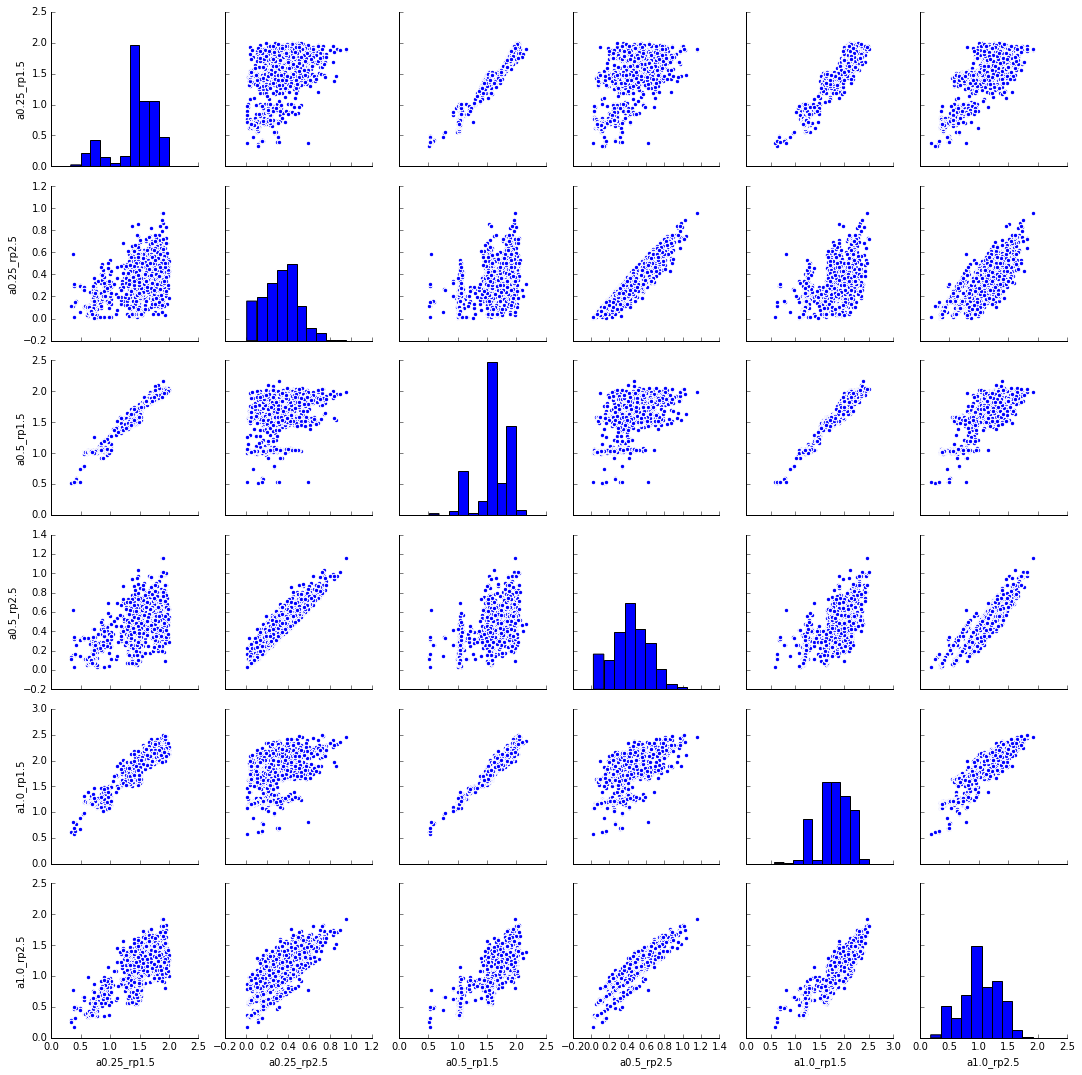

done


In [4]:
"""
4. visualization
"""
import seaborn
def plot_pair(df):
    """
    seaborn parplot of descriptors
    plot     (X[:,i],X[:,j])
    
    @param df : DataFrame
    """
    print("making pairplot")
    X = df.as_matrix().astype(np.float64)
    for x in X:
        for y in x:
            if not isinstance(y,np.float64):
                print (y)
    df2 = df.astype(np.float64)
    sns.pairplot(df2)
    plt.show()
    print("done")

plot_pair(df)